# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ALE
from alibi.explainers import ALE, plot_ale

## Parameters

In [2]:
scope = 'OFF'

input_path = f'../data/2_processed/ML_dataset_{scope}.pkl'

train_years = [2021]
test_years = [2022]

subsample_frac = None
run_ALE = False

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
]

features = other_features + features_to_encode

In [3]:
province_codes = {
    'Milano': 'MI',
    'Belluno': 'BL',
    'Bologna': 'BO',
    'Verona': 'VR',
    'Bolzano': 'BZ',
    'Bergamo': 'BG',
    'Cuneo': 'CN',
    'Vicenza': 'VI',
    'Pordenone': 'PN',
    'Lodi': 'LO',
    'Brescia': 'BS',
    'Treviso': 'TV',
    'Venezia': 'VE',
    'Sondrio': 'SO',
    'Verbano-Cusio-Ossola': 'VB',
    'Como': 'CO',
    'Aosta': 'AO',
    'Torino': 'TO',
    'Trento': 'TN',
    'Gorizia': 'GO',
    'Vercelli': 'VC',
    'Novara': 'NO',
    'Pavia': 'PV',
    'Mantova': 'MN',
    'Ravenna': 'RA',
    'Varese': 'VA',
    'Ferrara': 'FE',
    'Udine': 'UD',
    'Savona': 'SV',
    'Piacenza': 'PC',
    'La Spezia': 'SP',
    'Genova': 'GE',
    'Reggio Emilia': 'RE'
}

# Main

## Load data

In [4]:
input_df = pd.read_pickle(input_path)
print("{:,}".format(len(input_df)))
input_df.head(3)

3,574,411


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.419,False,0.0,195.5
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.433,False,0.0,195.5
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.0,0.0,111.74,0.451,False,0.0,195.5


In [5]:
# Subsample
if subsample_frac is not None:
    print(f'Subsampled {100*subsample_frac:.0f}% rows from the input dataset')
    df = input_df.sample(frac=subsample_frac)
else:
    df = input_df.copy()

print('Input dataset is composed of {:,} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {:,} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {:,} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Input dataset is composed of 3,574,411 observations
3.6% bids accepted in the input dataset

Training data is composed of 666,468 observations and correspond to years 2021
3.8% bids accepted in the training data

Test data is composed of 612,577 observations and correspond to years 2022
3.4% bids accepted in the test data


In [6]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['hour' 'SC_PC1' 'SC_PC2' 'IN_PC1' 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP'
 'SellMGP' 'SolarAngle' 'DeclAngle' 'PVnew' 'PriceDiff' 'MargTech'
 'WorkDay' 'Prov' 'Tech']


## Load model

In [7]:
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))
clf = joblib.load(model_path)
print(f'Model {model_path} loaded\n')

Model OFF/model_dumps/model_trained_OFF_2021.joblib loaded



## Permutation Feature Importance

In [8]:
clf_pipeline = make_pipeline(feature_transformer, clf)

In [9]:
train_result = permutation_importance(
    clf_pipeline, train_df[features], y_train, scoring='average_precision', random_state=42, n_jobs=-1
)

In [10]:

test_result = permutation_importance(
    clf_pipeline, test_df[features], y_test, scoring='average_precision', random_state=42, n_jobs=-1
)

In [11]:
sorted_importances_idx = test_result.importances_mean.argsort()

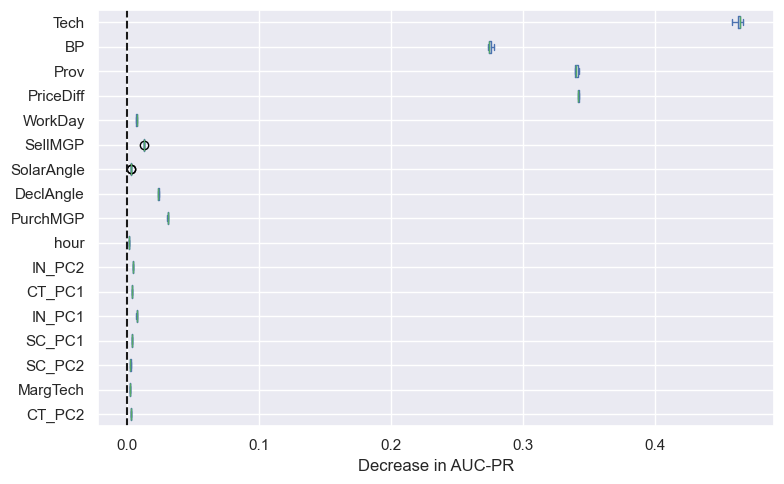

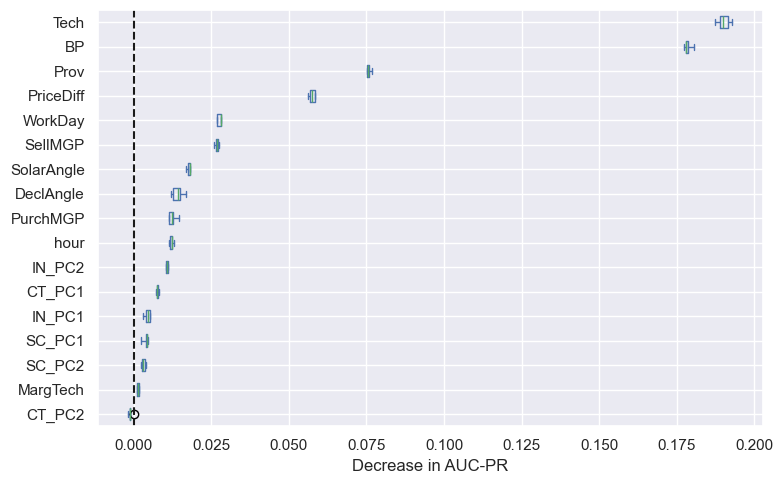

In [12]:
columns = train_df[features].columns[sorted_importances_idx]
columns = ['BP' if col == 'PVnew' else col for col in columns]

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=columns,
)
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=columns,
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
# for name, importances in zip(["train"], [train_importances]):
    ax = importances.plot.box(vert=False, whis=10, figsize=(8,5))
    # ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in AUC-PR")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

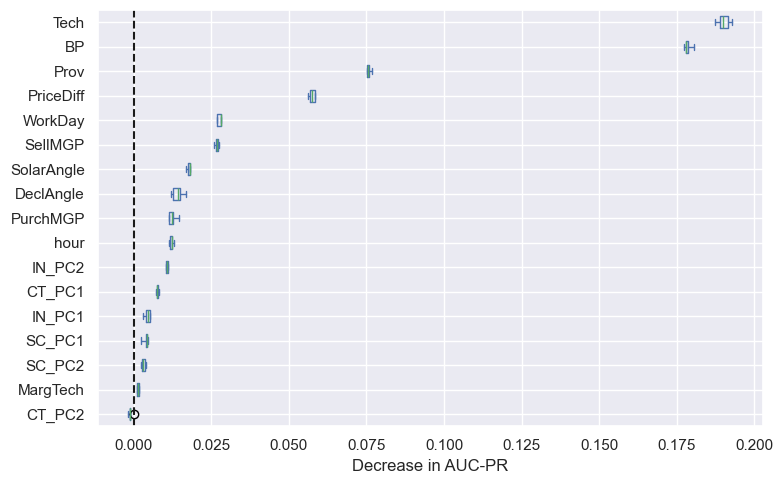

In [13]:
columns = train_df[features].columns[sorted_importances_idx]
columns = ['BP' if col == 'PVnew' else col for col in columns]
test_importances = pd.DataFrame(
    test_result.importances[sorted_importances_idx].T,
    columns=columns,
)
ax = test_importances.plot.box(vert=False, whis=10, figsize=(8,5))
# ax.set_title(f"Permutation Importances ({name} set)")
ax.set_xlabel("Decrease in AUC-PR")
ax.axvline(x=0, color="k", linestyle="--")
ax.figure.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/pfi_{scope}_test.png')

In [14]:
test_importances

,CT_PC2,MargTech,SC_PC2,SC_PC1,IN_PC1,CT_PC1,IN_PC2,hour,PurchMGP,DeclAngle,SolarAngle,SellMGP,WorkDay,PriceDiff,Prov,BP,Tech
0,-0.001744,0.001150,0.003485,0.004448,0.004542,0.008033,0.010452,0.012256,0.014547,0.016860,0.018091,0.027456,0.028043,0.058334,0.075165,0.178035,0.188920
1,-0.001167,0.001831,0.002362,0.004632,0.002922,0.007729,0.010908,0.011425,0.011375,0.014885,0.018000,0.026563,0.026858,0.056243,0.075869,0.180506,0.187339
2,0.000041,0.001330,0.002667,0.002282,0.005152,0.007083,0.010468,0.012849,0.011497,0.012689,0.018104,0.027247,0.026897,0.058335,0.076717,0.177280,0.192903
3,-0.001182,0.001817,0.003933,0.004244,0.004021,0.007528,0.011007,0.012397,0.012637,0.011949,0.017489,0.025818,0.028019,0.057578,0.075101,0.177878,0.189922
4,-0.001229,0.001168,0.002945,0.004004,0.005334,0.007526,0.010579,0.011576,0.012355,0.014422,0.016860,0.026829,0.028055,0.056926,0.075593,0.178459,0.191425


## Partial Dependence Plot

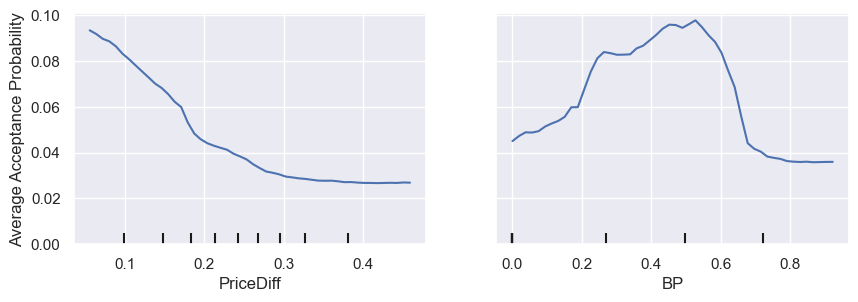

In [15]:
disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['PriceDiff', 'PVnew'],
    # categorical_features = np.array([col in features_to_encode for col in test_df[features].columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'average'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    n_cols = 2,  # This arranges the subplots in two columns
)

# xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
# disp.figure_.axes[1].set_xticklabels(xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['PriceDiff', 'BP']
# # Change the y-axis labels for each subplot
# y_labels = ['Average Acceptance Probability', 'Average Acceptance Probability']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(disp.axes_.ravel(), x_labels):
    ax.set_xlabel(label)

disp.axes_[0,0].set_ylabel('Average Acceptance Probability')
disp.axes_[0,0].set_ylim(bottom=0)
disp.axes_[0,1].set_ylim(bottom=0)

# # Set the y-axis limits and labels
# for ax, x_label, y_label in zip(disp.axes_.ravel(), x_labels, y_labels):
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
#     ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

# # Force the subplots to share the same y-axis
# for ax in disp.axes_.ravel()[1:]:  # Skip the first subplot as it will be the reference
#     ax.get_shared_y_axes().join(disp.axes_.ravel()[0], ax)

disp.figure_.set_size_inches(10,3)
disp.figure_.subplots_adjust(hspace=0.1)
plt.savefig(f'../plots/{scope}/explainer/pdp_price_pv_{scope}_test.png')

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_11159/4114077146.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(tech_xtick_names)
/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_11159/4114077146.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(prov_xtick_names)


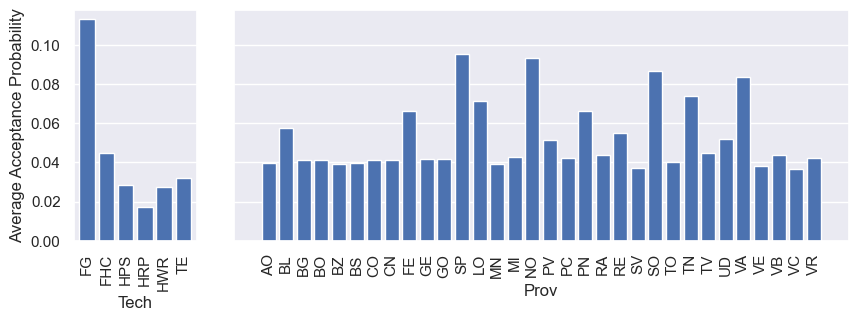

In [16]:
fig, axs = plt.subplots(1, 2, width_ratios=[1, 5], figsize=(10, 3), sharey=True)

disp = PartialDependenceDisplay.from_estimator(
    clf_pipeline,
    X = test_df[features],
    features = ['Tech', 'Prov'],
    categorical_features = ['Tech', 'Prov'],
    n_jobs = -1,
    kind = ['average', 'average'],
    subsample = 100,
    grid_resolution = 50,  # Optional: controls the resolution of the grid for plotting
    # n_cols = 2,  # This arranges the subplots in two columns
    ax = axs
)

tech_xtick_names = ['FG', 'FHC', 'HPS', 'HRP', 'HWR', 'TE']
prov_xtick_names = [province_codes[prov] for prov in sorted(province_codes.keys())]
axs[0].set_xticklabels(tech_xtick_names)
axs[1].set_xticklabels(prov_xtick_names)

# Change the x-axis labels for each subplot
x_labels = ['Tech', 'Prov']
# # Change the y-axis labels for each subplot
# y_labels = ['Average Acceptance Probability', 'Average Acceptance Probability']

# Iterate over each subplot and set the x-axis label
for ax, label in zip(axs, x_labels):
    ax.set_xlabel(label)
    ax.grid(False, axis='x')

axs[0].set_ylabel('Average Acceptance Probability')
axs[1].set_ylabel(None)
axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)

# # Set the y-axis limits and labels
# for ax, x_label, y_label in zip(disp.axes_.ravel(), x_labels, y_labels):
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
#     ax.set_ylim(bottom=0)  # Set the y-axis to start at 0

# # Force the subplots to share the same y-axis
# for ax in disp.axes_.ravel()[1:]:  # Skip the first subplot as it will be the reference
#     ax.get_shared_y_axes().join(disp.axes_.ravel()[0], ax)

plt.subplots_adjust(wspace=0.1, hspace=0)  # Adjust space between the plots
plt.savefig(f'../plots/{scope}/explainer/pdp_cat_{scope}_test.png', bbox_inches='tight')

## Accumulated Local Effects (ALE)

In [17]:
if run_ALE:
    predictor = clf.predict_proba

    # Features to explain should be numerical or ordinal
    encoded_feature_names = list(feature_transformer.get_feature_names_out())
    features_to_explain = [encoded_feature_names.index(feature) for feature in ['PVnew', 'PriceDiff', 'IN_PC1']]

    ale = ALE(predictor, encoded_feature_names, target_names=['Rejected', 'Accepted'])
    ale = ale.explain(X_test.toarray(), features=features_to_explain)

    plot_ale(ale, targets=['Accepted'], n_cols=4, fig_kw={'figwidth': 20, 'figheight': 5}, sharey=None)
    plt.tight_layout()

<HR>

# TESTS